In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import time

seed = 777

In [2]:
import pickle

(train_X_folds, train_y_folds, test_X_folds, test_y_folds, feature_names_folds, reverse_map_folds) = pickle.load(open('data/prepared_data.pkl', 'rb'))

In [3]:
train_X = train_X_folds[0]
train_y = train_y_folds[0]
test_X = test_X_folds[0]
test_y = test_y_folds[0]
feature_names = feature_names_folds[0]
reverse_map = reverse_map_folds[0]

In [13]:
# SGDClassifier for Linear SVM with ROC Curve and AUC
print("\n=== SGDClassifier Linear SVM ===")

# Train SGDClassifier with hinge loss (equivalent to SVM)
print("Training SGDClassifier with hinge loss (Linear SVM)...")
start_time = time.time()

sgd_svm = SGDClassifier(
    loss='hinge',           # Hinge loss = SVM
    max_iter=1000,
    random_state=42,
    class_weight='balanced',
    learning_rate='optimal',
    verbose=1               # Show progress
)

sgd_svm.fit(train_X, train_y)
sgd_training_time = time.time() - start_time

# Make predictions and get decision scores
sgd_pred = sgd_svm.predict(test_X)
sgd_decision_scores = sgd_svm.decision_function(test_X)

# Calculate accuracy
sgd_accuracy = accuracy_score(test_y, sgd_pred)

print(f"SGD SVM Training time: {sgd_training_time:.2f} seconds")
print(f"SGD SVM Accuracy: {sgd_accuracy:.4f}")


=== SGDClassifier Linear SVM ===
Training SGDClassifier with hinge loss (Linear SVM)...
-- Epoch 1
Norm: 22.94, NNZs: 410, Bias: -0.616814, T: 81332, Avg. loss: 6.366425
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 14.90, NNZs: 413, Bias: -1.431208, T: 162664, Avg. loss: 1.635864
Total training time: 0.14 seconds.
-- Epoch 3
Norm: 12.11, NNZs: 413, Bias: -0.434499, T: 243996, Avg. loss: 1.284753
Total training time: 0.22 seconds.
-- Epoch 4
Norm: 10.55, NNZs: 414, Bias: -0.631744, T: 325328, Avg. loss: 1.128721
Total training time: 0.30 seconds.
-- Epoch 5
Norm: 9.64, NNZs: 414, Bias: -0.626838, T: 406660, Avg. loss: 1.053655
Total training time: 0.38 seconds.
-- Epoch 6
Norm: 9.30, NNZs: 415, Bias: -0.383576, T: 487992, Avg. loss: 0.990133
Total training time: 0.46 seconds.
-- Epoch 7
Norm: 8.93, NNZs: 415, Bias: -0.875110, T: 569324, Avg. loss: 0.962878
Total training time: 0.54 seconds.
-- Epoch 8
Norm: 8.56, NNZs: 415, Bias: -0.719936, T: 650656, Avg. loss: 0.947596
Total t


=== ROC Curve and AUC Analysis ===
SGD SVM AUC: 0.6654


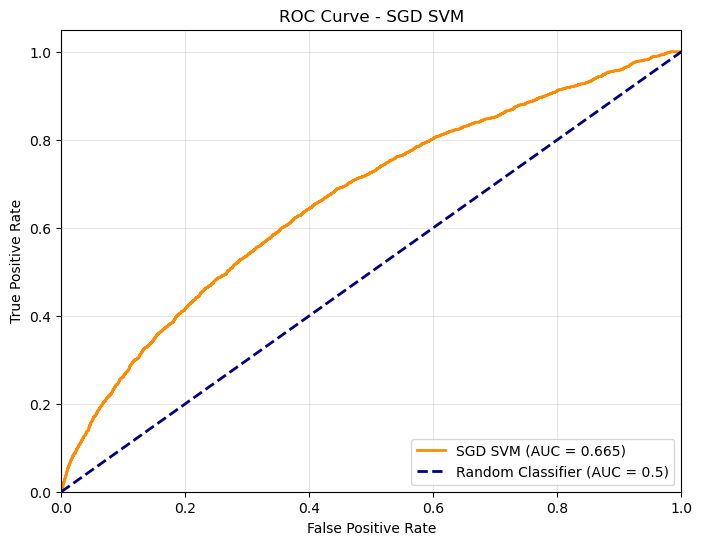


=== SGD SVM Performance Analysis ===
SGD SVM Confusion Matrix:
                 Predicted
                No Readmit  Readmit
Actual No Readmit     11959      6150
Actual Readmit           975      1350

SGD SVM Performance Metrics:
Accuracy:  0.6513
Precision: 0.1800
Recall:    0.5806
F1-Score:  0.2748
AUC:       0.6654


In [14]:
# ROC Curve and AUC
print("\n=== ROC Curve and AUC Analysis ===")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_y, sgd_decision_scores)
roc_auc = auc(fpr, tpr)

print(f"SGD SVM AUC: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'SGD SVM (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SGD SVM')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# SGD SVM Performance Analysis
print(f"\n=== SGD SVM Performance Analysis ===")

# Confusion matrix
sgd_cm = confusion_matrix(test_y, sgd_pred)
print("SGD SVM Confusion Matrix:")
print("                 Predicted")
print("                No Readmit  Readmit")
print(f"Actual No Readmit    {sgd_cm[0,0]:6d}    {sgd_cm[0,1]:6d}")
print(f"Actual Readmit        {sgd_cm[1,0]:6d}    {sgd_cm[1,1]:6d}")

# Calculate metrics
sgd_tn, sgd_fp, sgd_fn, sgd_tp = sgd_cm.ravel()
sgd_precision = sgd_tp / (sgd_tp + sgd_fp) if (sgd_tp + sgd_fp) > 0 else 0
sgd_recall = sgd_tp / (sgd_tp + sgd_fn) if (sgd_tp + sgd_fn) > 0 else 0
sgd_f1 = 2 * (sgd_precision * sgd_recall) / (sgd_precision + sgd_recall) if (sgd_precision + sgd_recall) > 0 else 0

print(f"\nSGD SVM Performance Metrics:")
print(f"Accuracy:  {sgd_accuracy:.4f}")
print(f"Precision: {sgd_precision:.4f}")
print(f"Recall:    {sgd_recall:.4f}")
print(f"F1-Score:  {sgd_f1:.4f}")
print(f"AUC:       {roc_auc:.4f}")

In [18]:
# Calculate standard deviation for each feature
feature_std = np.std(train_X, axis=0)

# Get raw coefficients
raw_coef = svm_model.coef_[0]

# Calculate adjusted feature importance: |coefficient| * std_dev
feature_importance = np.abs(raw_coef) * feature_std

# Normalize the adjusted importance
feature_importance = feature_importance / feature_importance.sum()

# Get top 30 most important features
top_indices = np.argsort(feature_importance)[-30:]
top_features = [feature_names[i] for i in top_indices]
top_importance = feature_importance[top_indices]

print(f"\nTop 30 Most Important Features (Std-Adjusted):")
for i, (feature, importance) in enumerate(zip(top_features, top_importance)):
    print(f"{i+1:2d}. {feature}: {importance:.4f}")


Top 30 Most Important Features (Std-Adjusted):
 1. gender_Male x age_[30-40): 0.0060
 2. race_AfricanAmerican x age_[60-70): 0.0061
 3. gender_Male x age_[90-100): 0.0064
 4. number_emergency: 0.0065
 5. admission_source_id_17: 0.0065
 6. race_Asian: 0.0069
 7. discharge_disposition_id_2: 0.0075
 8. diag_PC7: 0.0078
 9. diag_PC19: 0.0079
10. discharge_disposition_id_5: 0.0100
11. diag_PC1: 0.0100
12. age_[20-30): 0.0103
13. age_[90-100): 0.0105
14. race_AfricanAmerican: 0.0112
15. age_[30-40): 0.0119
16. discharge_disposition_id_3: 0.0121
17. age_[40-50): 0.0146
18. gender_Male x age_[40-50): 0.0152
19. discharge_disposition_id_22: 0.0159
20. gender_Male x age_[80-90): 0.0162
21. gender_Male x age_[50-60): 0.0184
22. age_[50-60): 0.0191
23. gender_Male x age_[70-80): 0.0210
24. gender_Male x age_[60-70): 0.0232
25. age_[60-70): 0.0234
26. age_[80-90): 0.0256
27. age_[70-80): 0.0279
28. number_inpatient: 0.0292
29. gender_Male: 0.0327
30. discharge_disposition_id_11: 0.0390


In [19]:
print("\n=== RBF Kernel SVM ===")

# Train RBF SVM with balanced classes
print("Training RBF SVM with balanced classes...")
start_time = time.time()

rbf_svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    random_state=seed,
    verbose=True
)

rbf_svm.fit(train_X, train_y)
rbf_training_time = time.time() - start_time

# Make predictions
start_time = time.time()
rbf_pred = rbf_svm.predict(test_X)
rbf_prediction_time = time.time() - start_time

# Calculate accuracy
rbf_accuracy = accuracy_score(test_y, rbf_pred)

print(f"RBF Training time: {rbf_training_time:.2f} seconds")
print(f"RBF Prediction time: {rbf_prediction_time:.4f} seconds")
print(f"RBF SVM Accuracy: {rbf_accuracy:.4f}")



=== RBF Kernel SVM ===
Training RBF SVM with balanced classes...
[LibSVM].................................................................................*................*.*
optimization finished, #iter = 97504
obj = -46757.341768, rho = -0.640467
nSV = 62679, nBSV = 51170
Total nSV = 62679
RBF Training time: 2457.44 seconds
RBF Prediction time: 211.8204 seconds
RBF SVM Accuracy: 0.7192


In [ ]:
# RBF SVM Performance Analysis
print("\n=== RBF SVM Performance Analysis ===")

# Classification report
print("RBF SVM Classification Report:")
print(classification_report(test_y, rbf_pred))

# Confusion matrix in table form
print("\nRBF SVM Confusion Matrix:")
rbf_cm = confusion_matrix(test_y, rbf_pred)
print("                 Predicted")
print("                No Readmit  Readmit")
print(f"Actual No Readmit    {rbf_cm[0,0]:6d}    {rbf_cm[0,1]:6d}")
print(f"Actual Readmit        {rbf_cm[1,0]:6d}    {rbf_cm[1,1]:6d}")

# Calculate metrics
rbf_tn, rbf_fp, rbf_fn, rbf_tp = rbf_cm.ravel()
rbf_precision = rbf_tp / (rbf_tp + rbf_fp) if (rbf_tp + rbf_fp) > 0 else 0
rbf_recall = rbf_tp / (rbf_tp + rbf_fn) if (rbf_tp + rbf_fn) > 0 else 0
rbf_f1 = 2 * (rbf_precision * rbf_recall) / (rbf_precision + rbf_recall) if (rbf_precision + rbf_recall) > 0 else 0

# Compare with Linear SVM
print(f"\n=== Linear vs RBF SVM Comparison ===")
print(f"Metric           Linear SVM    RBF SVM")
print(f"Accuracy:       {sgd_accuracy:.4f}      {rbf_accuracy:.4f}")
print(f"Precision:      {sgd_precision:.4f}      {rbf_precision:.4f}")
print(f"Recall:         {sgd_recall:.4f}      {rbf_recall:.4f}")
print(f"F1-Score:       {sgd_f1:.4f}      {rbf_f1:.4f}")
print(f"Training Time:  {sgd_training_time:.2f}s        {rbf_training_time:.2f}s")



=== RBF SVM Performance Analysis ===
RBF SVM Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.75      0.83     18109
        True       0.19      0.46      0.27      2325

    accuracy                           0.72     20434
   macro avg       0.55      0.61      0.55     20434
weighted avg       0.83      0.72      0.76     20434


RBF SVM Confusion Matrix:
                 Predicted
                No Readmit  Readmit
Actual No Readmit     13621      4488
Actual Readmit          1250      1075

RBF SVM Performance Metrics:
Accuracy:  0.7192
Precision: 0.1932
Recall:    0.4624
F1-Score:  0.2726

=== Linear vs RBF SVM Comparison ===
Metric           Linear SVM    RBF SVM
Accuracy:       0.6553      0.7192
Precision:      0.1800      0.1932
Recall:         0.5708      0.4624
F1-Score:       0.2737      0.2726
Training Time:  21.15s        7128.21s
Prediction Time: 0.0154s      210.4985s
